In [47]:
"""Import CSV Guppy data"""
import pandas as pd
import time
%matplotlib ipympl
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
"""Format notebook to work with CSV Guppy data"""
df = pd.read_csv("L230110.CSV", nrows=1347) # only looking at rows for first run (up to row 1347)
columns = [
        'Date', 'Time', 'Lat', 'Lon', 'Speed m/s', 'Distance km',
        'RPM 1', 'Motor Load 1 %%', 'Motor Torque 1 %%', 'Motor Temp 1 C',
        # 'RPM 2', 'Motor Load 2 %%', 'Motor Torque 2 %%', 'Motor Temp 2 C',
        # 'RPM 3', 'Motor Load 3 %%', 'Motor Torque 3 %%', 'Motor Temp 3 C',
        # 'RPM 4', 'Motor Load 4 %%', 'Motor Torque 4 %%', 'Motor Temp 4 C',
        # 'Depth m',
        # 'Temp Source 1', 'Temp 1 C',
        # 'Temp Source 2', 'Temp 2 C',
        # 'Temp Source 3', 'Temp 3 C',
        # 'Temp Source 4', 'Temp 4 C',
        'Pack Current 1 A', 'Pack Voltage 1 V', 'Pack Temp 1 C', 'SOC 1 %%',
        # 'Pack Current 2 A', 'Pack Voltage 2 V', 'Pack Temp 2 C', 'SOC 2 %%',
        # 'Pack Current 3 A', 'Pack Voltage 3 V', 'Pack Temp 3 C', 'SOC 3 %%',
        # 'Pack Current 4 A', 'Pack Voltage 4 V', 'Pack Temp 4 C', 'SOC 4 %%'
        ]
df = df[columns]
df.head()

,Date,Time,Lat,Lon,Speed m/s,Distance km,RPM 1,Motor Load 1 %%,Motor Torque 1 %%,Motor Temp 1 C,Pack Current 1 A,Pack Voltage 1 V,Pack Temp 1 C,SOC 1 %%
0,23-01-10,11:24:48,45.560810,-122.720818,0.000000,12.451462,0,0,0,0.000000,-4.700000,32.110001,297.000000,48
1,23-01-10,11:24:49,45.560837,-122.720711,0.000000,12.451462,0,0,0,0.000000,-4.700000,32.119999,297.000000,48
2,23-01-10,11:24:50,45.560837,-122.720711,0.000000,12.451462,0,0,0,0.000000,-4.700000,32.110001,297.000000,48
3,23-01-10,11:24:51,45.560833,-122.720711,0.000000,12.451462,0,0,0,0.000000,-4.700000,32.119999,297.000000,48
4,23-01-10,11:24:52,45.560837,-122.720711,0.000000,12.451462,0,0,0,0.000000,-4.700000,32.110001,297.000000,48


In [49]:
"""Clean non-numeric data rows by trying to convert to a 
float value and dropping the row if it is unable to."""

cnt=0
for row in df['Speed m/s']: # Arbitrary column that has numbers
    try:
        float(row)
        pass
    except ValueError:
        df.drop(cnt, inplace=True)
    cnt+=1

df.reset_index(inplace=True)

In [50]:
"""Test Loop:
Loop through CSV rows and update estimated mileage on each iteration.
This version is based on a known avg consumption rate.

For some reason it seems like this loops through twice because the values jump back up,
but initially it works. Haven't debugged it yet."""

df['SOC 1 %%'] = df['SOC 1 %%'].astype(int)     # Change batt charge to a integer
avg_consumption_rate = 6                        #kWh/km [Random Guess]

for i in range(len(df)):
    batt = df['SOC 1 %%'].iloc[i]*63/100        # Change into kWh based on 63 kWh full charge
    dist = batt/avg_consumption_rate            # In km. Will eventually need to be nm
    print('Battery Remaining = %d kWh | Distance Remaining = %d km' % (batt, dist), end='\r')
    time.sleep(.01)

TypeError: unhashable type: 'numpy.ndarray'

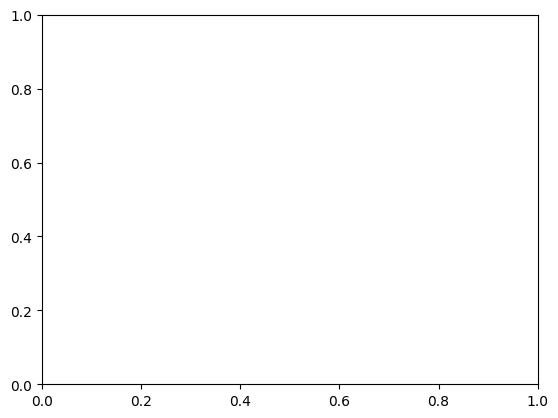

In [51]:
"""Test Loop for Plot: An attempt to plot time versus distance remaining, 
   calculated every 10 seconds in order to smooth final curve.
   Currently not yet working, running into error of 'Output exceeds the 
   size limit. Open the full output data in a text editor'. I am inclined 
   to believe that matplotlib has trouble processing datetime format of the 
   'Time' column. 
"""
distanceList = [] 
time1 = []
count = 0
for i in range(len(df)):
    batt = df['SOC 1 %%'].iloc[i]*63/100        # Change into kWh based on 63 kWh full charge
    dist = batt/avg_consumption_rate            # In km. Will eventually need to be nm
    count += 1
    if count % 10 == 0:
        time = df['Time']
        time1.append(time)
        distanceList.append(dist)

plt.plot(time1, distanceList)